# Init

In [29]:
from subprocess import call
from typing import List

import pandas as pd
import plotly.figure_factory as ff
from IPython.display import Image
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import f1_score, accuracy_score

In [30]:
ceramics = pd.read_csv('ceramics.tsv', sep='\t', decimal=',')

ceramics.drop(columns=['Номер_образца'], inplace=True)
ceramics.rename(columns={'Тип_керамики': 'Тип'}, inplace=True)

ceramics

,Территория,Тип,K,Ca,SiO2,Na,K.1,Ca.1,Mg,Ti,Fe
0,о. Сахалин,Охотский,0.05,0.04,0.94,0.48,0.48,0.04,0.01,0.16,0.83
1,о. Сахалин,Охотский,0.05,0.06,0.88,0.45,0.25,0.30,0.02,0.20,0.78
2,о. Сахалин,Охотский,0.16,0.06,0.78,0.40,0.43,0.17,0.03,0.13,0.83
3,о. Сахалин,Охотский,0.20,0.05,0.75,0.54,0.37,0.09,0.00,0.14,0.86
4,о. Сахалин,Охотский,0.09,0.01,0.89,0.43,0.50,0.08,0.03,0.12,0.85
...,...,...,...,...,...,...,...,...,...,...,...
74,г. Есаши,Охотский,0.27,0.26,0.47,0.57,0.22,0.21,0.26,0.15,0.59
75,г. Есаши,Охотский,0.14,0.53,0.33,0.41,0.12,0.47,0.32,0.20,0.48
76,г. Есаши,Охотский,0.15,0.63,0.22,0.56,0.09,0.35,0.11,0.33,0.56
77,г. Есаши,Охотский,0.15,0.56,0.29,0.52,0.10,0.37,0.37,0.26,0.37


In [31]:
RANDOM_STATE = 42

In [32]:
def plot_confusion_matrix(*, y_true: pd.Series, y_pred: pd.Series, classes: List[str], axis_title: str = 'Класс'):
    z = confusion_matrix(y_true=y_true, y_pred=y_pred, normalize='true', labels=classes)
    z_text = [[str(y) for y in x] for x in z]

    fig = ff.create_annotated_heatmap(z, x=classes, y=classes, showscale=True, annotation_text=z_text)
    fig.update_xaxes(title=axis_title, side='bottom')
    fig.update_yaxes(title=axis_title, autorange='reversed')
    fig.update_layout(title='Матрица ошибок')
    fig.show()

In [33]:
def report_model(model: DecisionTreeClassifier, X_test: pd.DataFrame, y_test: pd.Series):
    print(classification_report(y_test, model.predict(X_test)))

    plot_confusion_matrix(y_true=y_test, y_pred=model.predict(X_test), classes=y_test.unique().tolist())

    print(pd.DataFrame({'feature': X_test.columns, 'importance': model.feature_importances_}).sort_values('importance',
                                                                                                          ascending=False))

    export_graphviz(model,
                    out_file='tree.dot',
                    feature_names=model.feature_names_in_.tolist(),
                    label='root',
                    filled=True,
                    rotate=True,
                    )
    call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png'])
    return 'tree.png'

# Препроцессинг

## Проверка на nan

In [34]:
print(f'Количество отсутсвующих значений: {ceramics.isna().sum().sum()}')

Количество отсутсвующих значений: 0


## Разделяем данные на X и y

In [35]:
type_column = ['Тип']
territory_column = ['Территория']

X_columns = ceramics.columns.tolist()
X_columns.remove('Тип')
X_columns.remove('Территория')

X, type, territory = ceramics[X_columns], ceramics[type_column], ceramics[territory_column]

## Распределение классов

In [36]:
pd.concat([type.value_counts().rename('Количество'), type.value_counts(normalize=True).rename('Распределение')], axis=1)

,Количество,Распределение
Тип,,
Охотский,56,0.708861
Сусуйский,23,0.291139


In [37]:
pd.concat([territory.value_counts().rename('Количество'), territory.value_counts(normalize=True).rename('Распределение')],
          axis=1)

,Количество,Распределение
Территория,,
г. Вакканай,21,0.265823
о. Рисири,19,0.240506
о. Ребун,18,0.227848
о. Сахалин,15,0.189873
г. Есаши,6,0.075949


## Деление на test и train

In [38]:
X_type_train, X_type_test, type_train, type_test = train_test_split(X, type['Тип'], stratify=type['Тип'],
                                                                    random_state=RANDOM_STATE)

In [39]:
X_territory_train, X_territory_test, territory_train, territory_test = train_test_split(X, territory['Территория'],
                                                                                        stratify=territory[
                                                                                            'Территория'],
                                                                                        random_state=RANDOM_STATE)

# Поиск гиперпараметров

## Модель для типа

In [40]:
model = DecisionTreeClassifier(random_state=RANDOM_STATE)
model.fit(X, type)

DecisionTreeClassifier(random_state=42)

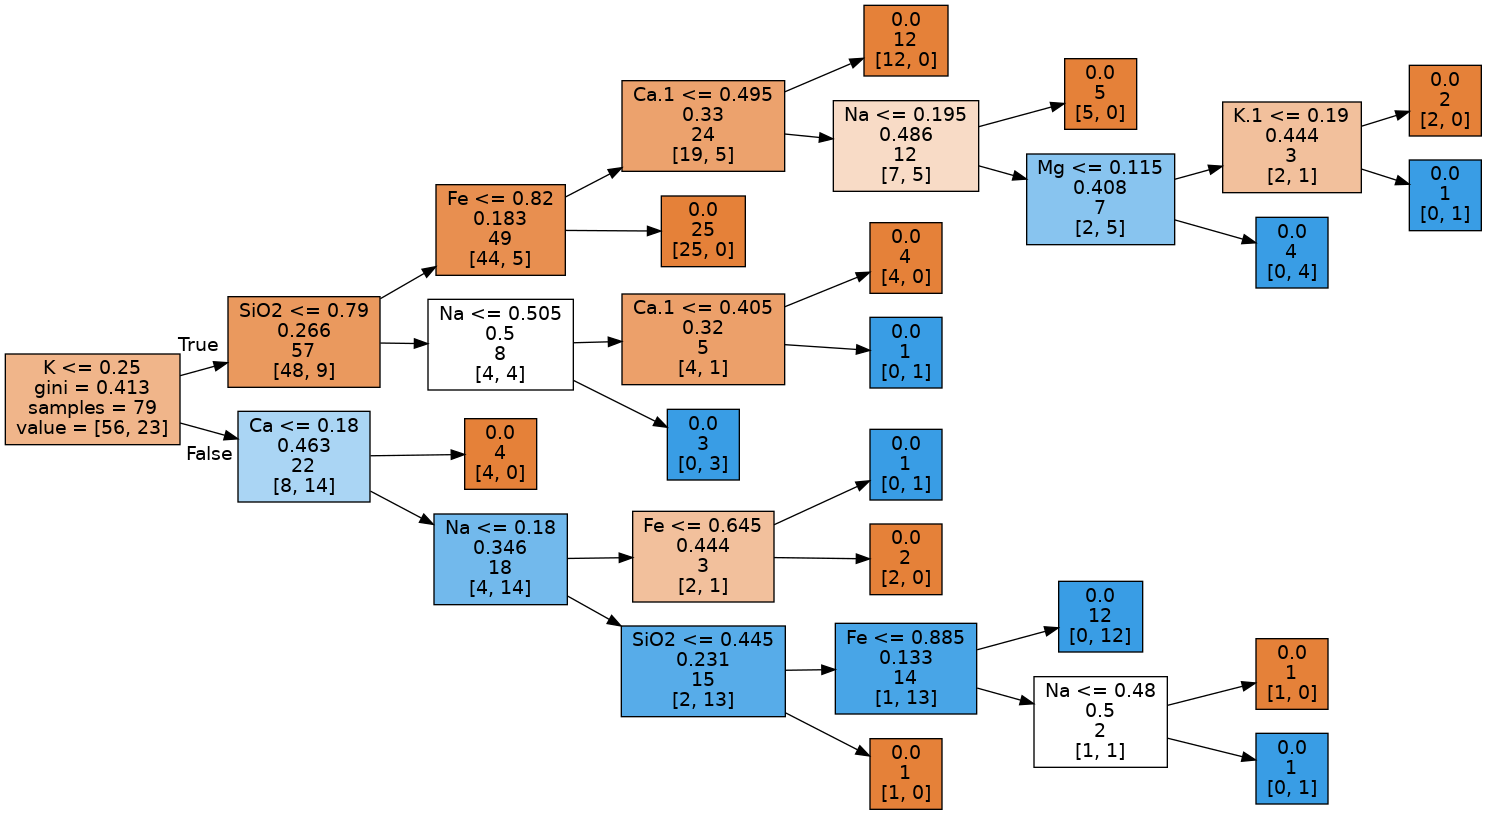

In [41]:
export_graphviz(model,
                out_file='tree.dot',
                feature_names=model.feature_names_in_.tolist(),
                label='root',
                filled=True,
                rotate=True,
                )

call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png'])
Image('tree.png')

In [42]:
# params = {
#     'criterion': ['gini', 'entropy'],
#     'max_depth': list(range(1, 6)),
#     'min_samples_split': list(range(6, 40)),
#     'min_samples_leaf': list(range(3, 40)),
# }
#
# grid_search = GridSearchCV(DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced'),
#                            param_grid=params, n_jobs=4, verbose=1000, scoring='f1_weighted')
# grid_search.fit(X_type_train, type_train)

In [43]:
# f1-weighted = 0.6933765898703979
type_best_params = {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 6, 'min_samples_split': 13}

# print(grid_search.best_params_)
# print(grid_search.best_score_)

In [44]:
type_model = DecisionTreeClassifier(random_state=RANDOM_STATE, **type_best_params)

              precision    recall  f1-score   support

    Охотский       0.73      0.79      0.76        14
   Сусуйский       0.40      0.33      0.36         6

    accuracy                           0.65        20
   macro avg       0.57      0.56      0.56        20
weighted avg       0.63      0.65      0.64        20



  feature  importance
0       K    0.353419
8      Fe    0.350404
5    Ca.1    0.188576
1      Ca    0.107601
2    SiO2    0.000000
3      Na    0.000000
4     K.1    0.000000
6      Mg    0.000000
7      Ti    0.000000


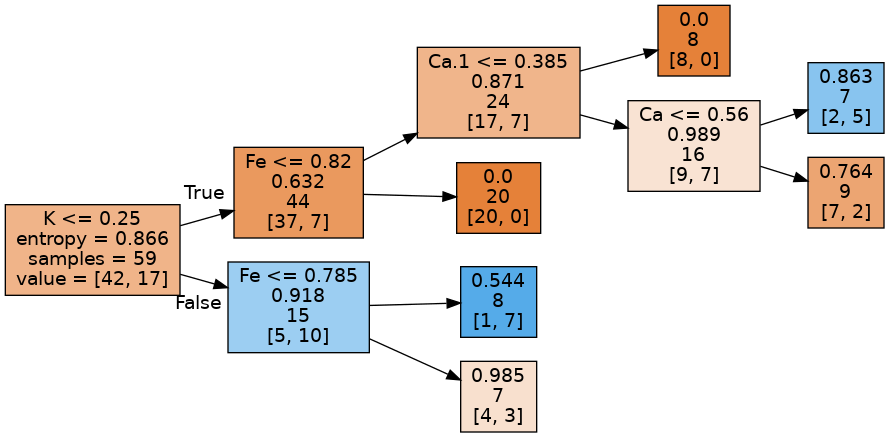

In [45]:
type_model.fit(X_type_train, type_train)
Image(report_model(type_model, X_type_test, type_test))

              precision    recall  f1-score   support

    Охотский       0.86      0.89      0.88        56
   Сусуйский       0.71      0.65      0.68        23

    accuracy                           0.82        79
   macro avg       0.79      0.77      0.78        79
weighted avg       0.82      0.82      0.82        79



  feature  importance
1      Ca    0.449408
2    SiO2    0.264082
0       K    0.153291
5    Ca.1    0.133219
3      Na    0.000000
4     K.1    0.000000
6      Mg    0.000000
7      Ti    0.000000
8      Fe    0.000000


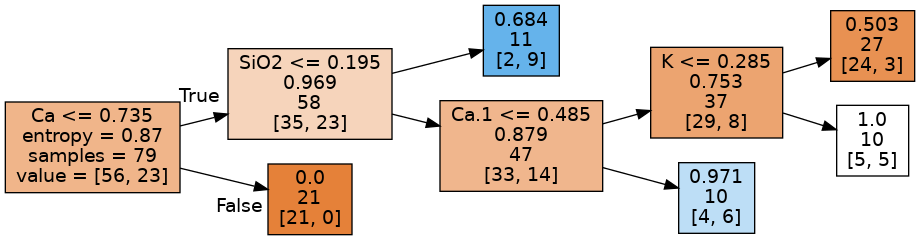

In [46]:
type_model.fit(X, type['Тип'])
Image(report_model(type_model, X, type['Тип']))

## Модель для территории

In [47]:
model = DecisionTreeClassifier(random_state=RANDOM_STATE)
model.fit(X, territory)

DecisionTreeClassifier(random_state=42)

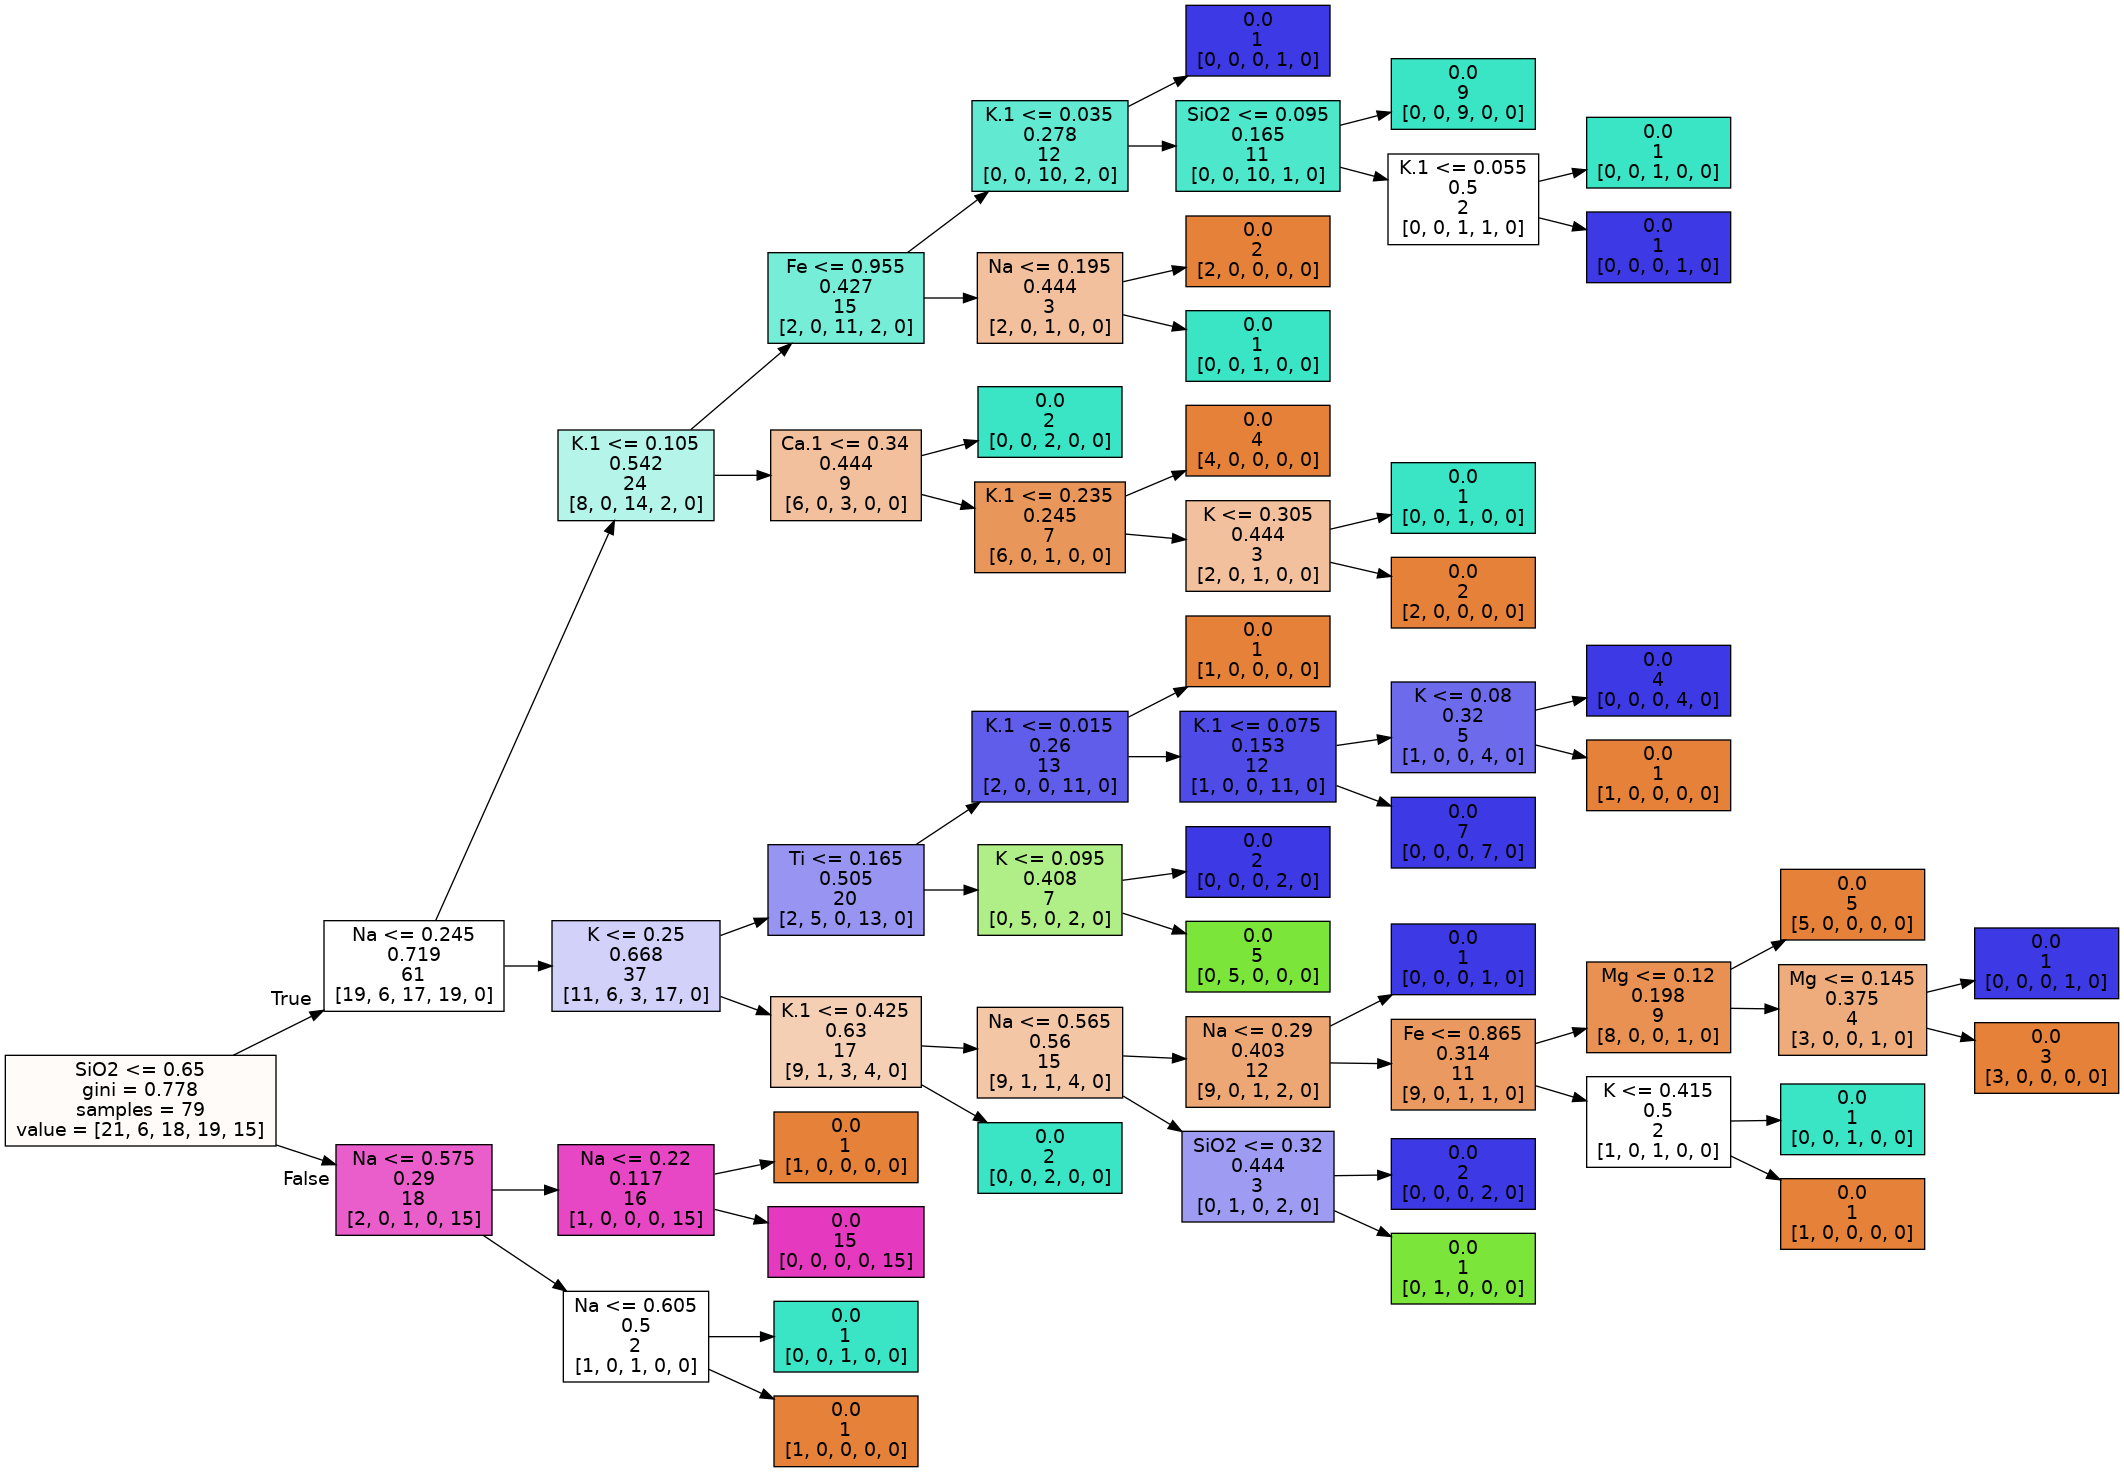

In [48]:
export_graphviz(model,
                out_file='tree.dot',
                feature_names=model.feature_names_in_.tolist(),
                label='root',
                filled=True,
                rotate=True,
                )

call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png'])
Image('tree.png')

In [49]:
# params = {
#     'criterion': ['gini', 'entropy'],
#     'max_depth': list(range(1, 8)),
#     'min_samples_split': list(range(6, 40)),
#     'min_samples_leaf': list(range(3, 40)),
# }
#
# grid_search = GridSearchCV(DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced'),
#                            param_grid=params, n_jobs=4, verbose=1000, scoring='f1_weighted')
# grid_search.fit(X_territory_train, territory_train)

In [50]:
# f1-weighted=0.533989898989899
territory_best_params = {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 9}

# print(grid_search.best_params_)
# print(grid_search.best_score_)

In [51]:
territory_model = DecisionTreeClassifier(random_state=RANDOM_STATE, **territory_best_params)

              precision    recall  f1-score   support

 г. Вакканай       0.50      0.40      0.44         5
    г. Есаши       0.00      0.00      0.00         1
    о. Ребун       0.50      0.40      0.44         5
   о. Рисири       0.57      0.80      0.67         5
  о. Сахалин       1.00      1.00      1.00         4

    accuracy                           0.60        20
   macro avg       0.51      0.52      0.51        20
weighted avg       0.59      0.60      0.59        20



  feature  importance
3      Na    0.366904
2    SiO2    0.295349
7      Ti    0.155480
6      Mg    0.090698
1      Ca    0.081880
4     K.1    0.009690
0       K    0.000000
5    Ca.1    0.000000
8      Fe    0.000000


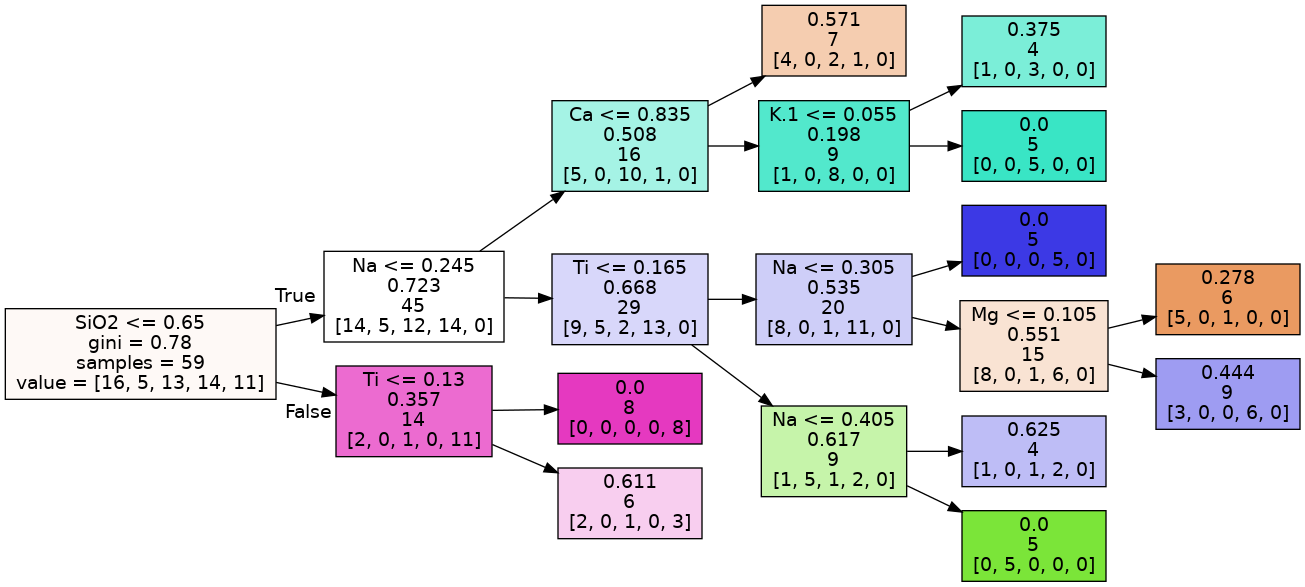

In [52]:
territory_model.fit(X_territory_train, territory_train)
Image(report_model(territory_model, X_territory_test, territory_test))

              precision    recall  f1-score   support

 г. Вакканай       0.65      0.62      0.63        21
    г. Есаши       0.71      0.83      0.77         6
    о. Ребун       0.75      0.67      0.71        18
   о. Рисири       0.78      0.74      0.76        19
  о. Сахалин       0.83      1.00      0.91        15

    accuracy                           0.75        79
   macro avg       0.75      0.77      0.76        79
weighted avg       0.74      0.75      0.74        79



  feature  importance
2    SiO2    0.378680
3      Na    0.165840
7      Ti    0.130611
0       K    0.105366
6      Mg    0.077676
4     K.1    0.070302
8      Fe    0.052112
5    Ca.1    0.019413
1      Ca    0.000000


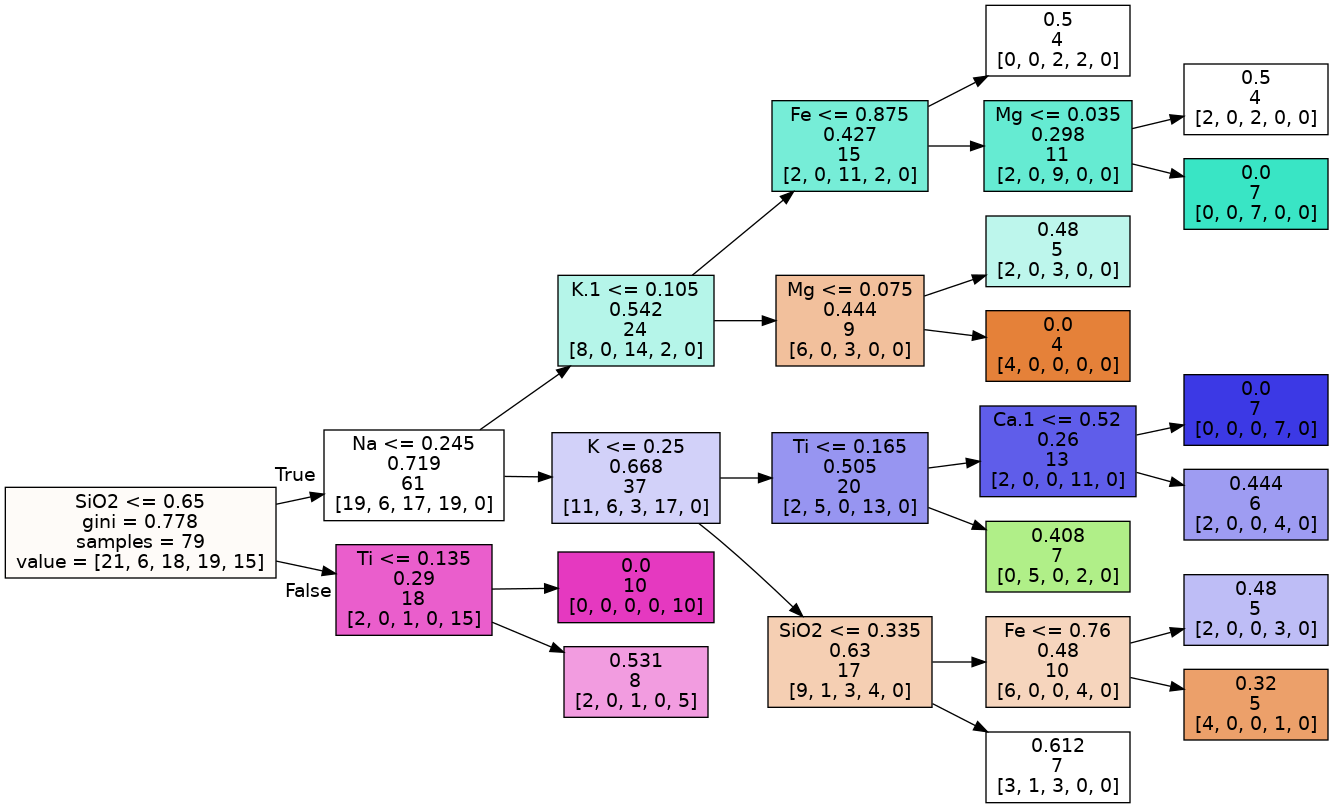

In [53]:
territory_model.fit(X, territory['Территория'])
Image(report_model(territory_model, X, territory['Территория']))

# Общая модель

## На всех данных

In [54]:
type_model.fit(X, type)
territory_model.fit(X, territory)

type_pred = type_model.predict(X)
territory_pred = territory_model.predict(X)

type_territory_pred = type_pred + ' | ' + territory_pred
y = pd.concat([type, territory], axis=1)
type_territory_true = y['Тип'] + ' | ' + y['Территория']

print(classification_report(type_territory_true, type_territory_pred, zero_division=0))
print(f'f1 = {f1_score(type_territory_true, type_territory_pred, average="weighted")}')
plot_confusion_matrix(y_true=type_territory_true, y_pred=type_territory_pred, classes=type_territory_true.unique().tolist())

                         precision    recall  f1-score   support

 Охотский | г. Вакканай       0.38      0.50      0.43        10
    Охотский | г. Есаши       1.00      0.83      0.91         6
    Охотский | о. Ребун       0.71      0.62      0.67        16
   Охотский | о. Рисири       0.80      0.67      0.73        12
  Охотский | о. Сахалин       0.75      1.00      0.86        12
Сусуйский | г. Вакканай       0.71      0.45      0.56        11
   Сусуйский | г. Есаши       0.00      0.00      0.00         0
   Сусуйский | о. Ребун       0.00      0.00      0.00         2
  Сусуйский | о. Рисири       0.50      0.57      0.53         7
 Сусуйский | о. Сахалин       0.50      0.33      0.40         3

               accuracy                           0.63        79
              macro avg       0.54      0.50      0.51        79
           weighted avg       0.67      0.63      0.64        79

f1 = 0.6395755653873431


## На тестовых данных

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=RANDOM_STATE)

In [56]:
type_model.fit(X_train, y_train['Тип'])
territory_model.fit(X_train, y_train['Территория'])

type_pred = type_model.predict(X_test)
territory_pred = territory_model.predict(X_test)
type_territory_pred = type_pred + ' | ' + territory_pred

type_territory_true = y_test['Тип'] + ' | ' + y_test['Территория']

print(classification_report(type_territory_true, type_territory_pred, zero_division=0))
print(f'f1 = {f1_score(type_territory_true, type_territory_pred, average="weighted")}')
plot_confusion_matrix(y_true=type_territory_true, y_pred=type_territory_pred, classes=type_territory_true.unique().tolist())

                         precision    recall  f1-score   support

 Охотский | г. Вакканай       0.00      0.00      0.00         3
    Охотский | г. Есаши       0.00      0.00      0.00         1
    Охотский | о. Ребун       0.20      0.25      0.22         4
   Охотский | о. Рисири       0.33      0.33      0.33         3
  Охотский | о. Сахалин       0.75      1.00      0.86         3
Сусуйский | г. Вакканай       0.67      0.67      0.67         3
   Сусуйский | г. Есаши       0.00      0.00      0.00         0
  Сусуйский | о. Рисири       0.00      0.00      0.00         2
 Сусуйский | о. Сахалин       0.00      0.00      0.00         1

               accuracy                           0.35        20
              macro avg       0.22      0.25      0.23        20
           weighted avg       0.30      0.35      0.32        20

f1 = 0.32301587301587303
